In [4]:
import numpy as np

In [5]:
q = np.zeros ((5,6))
c = np.zeros ((5,6))
l = []

l.append ([np.abs(q),np.abs(c)])
l.append ([np.abs(q),np.abs(c)])
l.append ([np.abs(q),np.abs(c)])
l.append ([np.abs(q),np.abs(c)])
l = np.asarray (l)


In [6]:
l.shape

(4, 2, 5, 6)

## Семинар 1 "Полносвязные нейронные сети"

ФИО: Белозёров Михаил Сергеевич

В этом задании вам предстоит реализовать проход "вперед" для полносвязной нейронную сети. В дальнейшем мы реализуем процедуру обучения и научим сеть распознавать рукописные цифры.

На первой лекции мы познакомились с тем, что такое нейронные сети и изучили три слоя — линейный, сигмоида и SoftMax. Из этих слоев можно составлять глубокие архитектуры и обучать их при помощи градиентного спуска. Чтобы конструировать сложные архитектуры, можно реализовать каждый тип слоя как отдельный "кирпичик" и затем собирать полную архитектуру как конструктор. Это мы и попробуем сделать на первом и втором семинарах.

Каждый тип слоя мы будем реализовывать при помощи класса, который будет поддерживать три функции: forward, которая будет применять функцию, реализуемую слоем, к входной матрице и backward, которая будет вычислять градиенты и step, которая будет обновлять веса. Чтобы не применять функцию к каждому объекту в отдельности, мы будем подавать на вход слою матрицу размера (N, d), где N — количество объектов, а d — размерность каждого объекта.

<img src=backprop.pdf width=400>

Функция forward будет вычислять по $x$ значение $y$, backward — по $\frac{\partial L}{\partial y}$ вычислять $\frac{\partial L}{\partial x}$ и обновлять внутри себя $\frac{\partial L}{\partial w}$.

Важным требованием к реализации является векторизация всех слоев: все операции должны быть сведены к матричным, не должно быть циклов. Это значительно уменьшает временные затраты.

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
%matplotlib inline

### Часть 1: Линейный слой


In [2]:
class Linear:
    def __init__(self, input_size, output_size):
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''
        #### YOUR CODE HERE
        #### Create weights, initialize them with samples from N(0, 0.1).
        self.weights=np.random.rand (output_size, input_size)
        self.weights=self.weights / 10
        self.biases=np.zeros(output_size)
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, input_size).
        Returns output of size (N, output_size).
        Hint: You may need to store X for backward pass
        '''
        #### YOUR CODE HERE
        #### Apply layer to input
        self.X=X
        return X.dot(self.weights.T) + self.biases
    
    def forward_w(self, W):
        return self.X.dot(W.T) + self.biases
    
    def backward(self, dLdy):
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        self.dLdw = np.dot(self.X.T, dLdy)
        return dLdy.dot(self.weights)
    
    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - l*dLdw
        '''
        #### YOUR CODE HERE
        self.weights = self.weights - learning_rate * self.dLdw.T

### Часть 2: Численный градиент

Релизуйте функцию проверки численного градиента. Для этого для каждой переменной, по которой считается градиент, надо вычислить численный градиент: $f'(x) \approx \frac{f(x+\epsilon)-f(x-\epsilon)}{2\epsilon}$. Функция должна возвращать максимальное абсолютное отклонение аналитического градиента от численного. В качестве $\epsilon$ рекомендуется взять $10^{-6}$. При правильной реализации максимальное отличие будет иметь порядок $10^{-8}-10^{-6}$.

In [3]:
def check_gradient(func, X, gradient):
    '''
    Computes numerical gradient and compares it with analytcal.
    func: callable, function of which gradient we are interested. Example call: func(X)
    X: np.array of size (n x m)
    gradient: np.array of size (n x m)
    Returns: maximum absolute diviation between numerical gradient and analytical.
    '''
    abs_max = 0
    eps = 1e-6

    gr = np.empty(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x_r = X.copy()
            x_l = X.copy()
            
            x_r[i][j] = X[i][j] + eps
            x_l[i][j] = X[i][j] - eps
#             print ("real grad: ", gradient[i][j], "we assume: ",(func(x_r) - func(x_l)).sum () / (2 * eps))             
            gr[i][j] = (func(x_r) - func(x_l)).sum () / (2 * eps) - gradient[i][j]       
    
    return gr.max()

Протестируйте линейный слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$ и $\frac{\partial L}{\partial w}$.

In [4]:
#### YOUR CODE HERE
input_size = 30
output_size = 50
lin_layer = Linear(input_size, output_size)
N = 100
X = np.random.rand(N, input_size)
lin_layer.forward(X)


lin_layer.forward(X)
lin_layer.backward(np.ones((N, output_size)))
W=np.random.rand (output_size, input_size)
print ('dLdw check: ', check_gradient(lin_layer.forward_w, W, lin_layer.dLdw.T))

('dLdw check: ', 1.1918785958187073e-08)


### Часть 3: Сигмоида

In [5]:
def sigma(x):
    return 1. / (1 + np.exp(-x))


class Sigmoid:
    def __init__(self):
        pass
        
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return sigma(self.X)
        
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        sigmoid_d = sigma(self.X) - np.power (sigma(self.X),2 )

        return np.multiply(dLdy, sigmoid_d)
    
    def step(self, learning_rate):
        pass

Протестируйте слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$.

In [6]:
#### YOUR CODE HERE
input_size = 100
sigm_layer = Sigmoid()
N = 100
X = np.random.rand(N, input_size)
sigm_layer.forward(X)
print ('dLdx check: ', check_gradient(sigm_layer.forward, X, sigm_layer.backward(np.ones((N, input_size)))))

('dLdx check: ', 1.1589751380824964e-10)


### Часть 4: Функция потерь

Как мы увидели на семинаре, вычисление производной для связки SoftMax + Negative log-likelihood проще чем для этих двух слоев по отдельности. Поэтому мы реализуем их как один класс. Важное замечание: на проходе "вперед" важно воспользоваться трюком <a href="https://hips.seas.harvard.edu/blog/2013/01/09/computing-log-sum-exp/">log-sum-exp</a>, чтобы не столкнуться с численными неустойчивостями.

In [7]:
import sklearn.preprocessing
def binarizer (Y):
    label_binarizer = sklearn.preprocessing.LabelBinarizer()
    label_binarizer.fit(range(Y.max () + 2))
    ret = label_binarizer.transform(Y)
    return ret[:,:ret.shape[1] - 1]

In [8]:
X = np.array ([[1,2],[3,4],[6,7]])
y = np.array ([0,1,0])
np.multiply (binarizer (y), X)

array([[1, 0],
       [0, 4],
       [6, 0]])

In [9]:
class NLLLoss:
    def init(self):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
        #### YOUR CODE HERE
        #### (Hint: No code is expected here, just joking)
        pass
    
    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, C), where C is the number of classes
        y is np.array of size (N), contains correct labels
        '''
        #### YOUR CODE HERE
        #### Apply layer to input
        log_max = np.amax(X, 1)
        self.bin = binarizer(y)
        summ = (X.T - log_max.T).T
        logg = np.log(np.sum(np.exp(summ), axis=1))
        summm = (logg.T + log_max.T).T        
        self.p = np.exp((X.T - summm.T).T)
        return self.p
    
    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        #### YOUR CODE HERE
        return self.p - self.bin

Протестируйте слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$.

In [10]:
from random import randint
C = 20
loss = NLLLoss()
N = 100
X = np.random.rand(N, C)
y = np.empty(N, dtype=int)
for i in range (N):
    y[i] = randint(0, C - 1)
loss.forward(X, y)
def forward_no_y(X):
    probs = loss.forward(X, y)
    return -np.log(np.amax(np.multiply(loss.bin, probs), axis=1))

print ('dLdx check: ', check_gradient(forward_no_y, X, loss.backward()))

('dLdx check: ', 4.757084032247505e-10)


### Часть 5, нейронная сеть

Теперь, когда у нас есть "кирпичики", мы можем написать класс, который будет собирать всю сеть вместе 

In [11]:
class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        #### YOUR CODE HERE
        self.modules = modules
    
    def forward(self, X):
        #### YOUR CODE HERE
        #### Apply layers to input
        res = X
        for l in self.modules:
            res = l.forward (res)
        return res
    
    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        #### YOUR CODE HERE
        newd = dLdy
        for l in reversed (self.modules):
            newd = l.backward (newd)
        return newd
    
    def step(self, learning_rate):
        for l in self.modules:
            l.step (learning_rate)
        pass



### Часть 6, обучение на простых данных

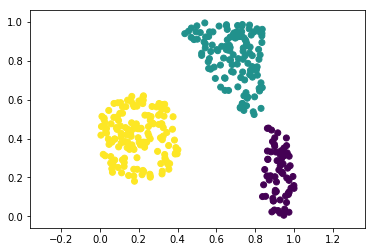

In [12]:
data = np.load('data.npz')
X, y = data['arr_0'], data['arr_1']
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')
plt.show()

Обучите архитектуру вида 2 -> 10 -> 10 -> 3:
* Linear(2, 10)
* Sigmoid()
* Linear(10, 10)
* Sigmoid()
* Linear(10, 3)

В качестве функции потерь используйте NLLLoss.
1. Создайте сеть, в цикле запускайте forward, backward, step (используйте learning rate 0.01). 
2. Нарисуйте график сходимости (изменение NLL со временем).
3. Нарисуйте разделяющую поверхность

Отличная визуализация: http://playground.tensorflow.org/

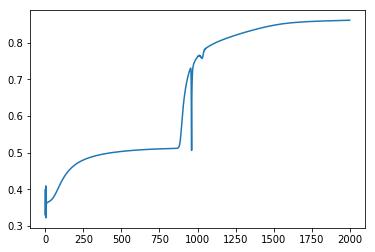

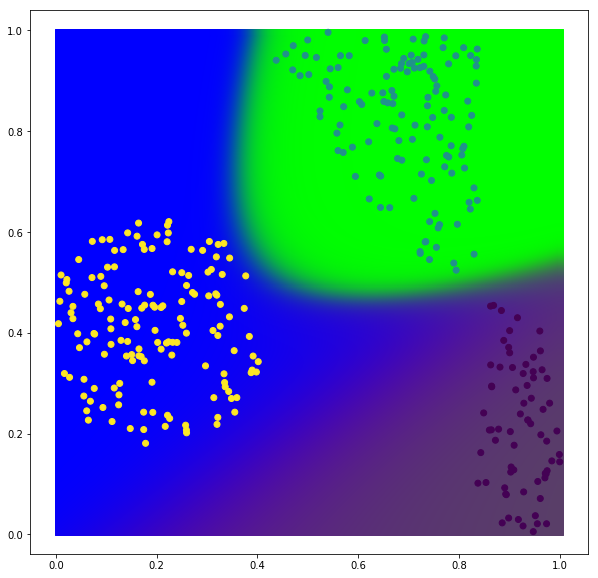

In [13]:
### YOUR CODE HERE:
first_lin = Linear (2,10)
sigmoid_1 = Sigmoid ()
second_lin = Linear (10,10)
sigmoid_2 = Sigmoid ()
third_lin = Linear (10,3)

loss = NLLLoss()
l_r = 0.01



nn = NeuralNetwork ([first_lin, sigmoid_1, second_lin, sigmoid_2, third_lin])
bina = binarizer (y)
error  =[]
x_error = []
for i in range(0,2000):
    x_error.append (i)
    res = nn.forward (X)
    result_io = loss.forward(res, y)
    error.append (np.multiply(bina, result_io).sum () / X.shape[0])
    nn.backward (loss.backward ())
    nn.step (l_r)


plt.plot (x_error,error, label="NNL")
plt.show ()


xx = np.linspace(min(X[:,0]),max(X[:,0]),500)
yy = np.linspace(min(X[:,1]),max(X[:,1]),500)

xc, yc = np.meshgrid(xx,yy)

plt.figure (figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], c=result_io)
plt.axis('equal')
Xgrid=np.array((xc.ravel(), yc.ravel())).T
plt.scatter(xc,yc,c=loss.forward(nn.forward(Xgrid), np.ones (500 * 500, dtype=int)),marker=",",cmap="prism")
plt.scatter(X[:,0],X[:,1],c=y)
plt.axis('equal')
plt.show()